In [15]:
import torch
from config import *

In [33]:
from datasets import *
B = 2
shuffle = 1
dataset = ToyDataWithQuestions()
dataloader = DataLoader(dataset, batch_size = B, shuffle = shuffle)
# [Get A Sample Data]
for sample in dataloader:
    sample = sample

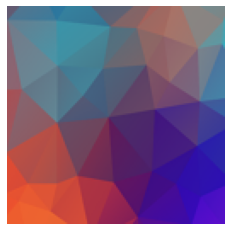

In [17]:
plt.axis("off")
plt.imshow(sample["image"][0])

In [18]:
config.perception = "valkyr"
model = SceneLearner(config)


In [136]:
import torch
import torch.nn as nn
from types import SimpleNamespace

class GraphConvolution(nn.Module):

    def __init__(self, input_feature_num, output_feature_num, add_bias=True, dtype=torch.float,
                 batch_normal=True):
        super().__init__()
        # shapes

        self.input_feature_num = input_feature_num
        self.output_feature_num = output_feature_num
        self.add_bias = add_bias
        self.batch_normal = batch_normal

        # params
        self.weight = nn.Parameter(torch.empty(self.output_feature_num, input_feature_num, dtype=dtype))
        #self.bias = nn.Parameter(torch.empty(self.output_feature_num, self.graph_num, dtype=dtype))

        self.sparse = True
            
    def set_trainable(self, train=True):
        for param in self.parameters():
            param.requires_grad = train

    def forward(self, x, adj):
        """
        @param inp : adjacent: (batch, graph_num, graph_num) cat node_feature: (batch, graph_num, in_feature_num) -> (batch, graph_num, graph_num + in_feature_num)
        @return:
        """
        B, N, D = x.shape
        node_feature = x
        x = torch.matmul(node_feature,self.weight.permute(1,0))
        if self.sparse or isinstance(adj, torch.SparseTensor):
            x = torch.spmm(adj,x[0]).unsqueeze(0)
        else:
            x = torch.matmul(x, adj)
        #if self.add_bias:
        #    x = x + self.bias

        return x

class GNNSoftPooling(nn.Module):
    def __init__(self, input_feat_dim, output_node_num = 10):
        super().__init__()
        self.assignment_net = GraphConvolution(input_feat_dim, output_node_num)
        self.feature_net =   GraphConvolution(input_feat_dim, input_feat_dim) 
    
    def forward(self, x, adj):
        B,N,D = x.shape
        # B,N,N = adj.shape
        if isinstance(adj, list):
            output_node_features = []
            output_new_adj = []
            output_s_matrix = []
            for i in range(len(adj)):
                s_matrix = self.assignment_net(x[i:i+1], adj[i]) #[B,N,M]
                node_features = self.feature_net(x[i:i+1],adj[i]) #[B,N,D]
                node_features = torch.einsum("bnm,bnd->bmd",s_matrix,node_features) #[B,M,D]
                # [Calculate New Cluster Adjacency]

                adj[i] = torch.Tensor.to_dense(adj[i])
                #print(torch.spmm(s_matrix[0],adj[i]).shape)
                new_adj = torch.spmm(
                    torch.spmm(
                        s_matrix[0].permute(1,0),adj[i]
                        ),s_matrix[0])

                output_node_features.append(node_features)
                output_new_adj.append(new_adj)
                output_s_matrix.append(s_matrix)

            output_node_features = torch.cat(output_node_features, dim = 0)
            output_s_matrix = torch.cat(output_s_matrix, dim = 0)
        return output_node_features,output_new_adj,output_s_matrix

class ObjectRender(nn.Module):
    def __init__(self,):
        super().__init__()

class ValkyrNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        device = config.device
        # construct the grid domain connection
        self.imsize = config.imsize
        self.perception_size = config.perception_size
        # build the connection graph for the grid domain
        self.spatial_coords = grid(self.imsize,self.imsize,device=device)
        self.spatial_edges =  build_perception(self.imsize,self.perception_size,device = device)
        # [Grid Convs]
        conv_feature_dim = config.conv_feature_dim
        self.grid_convs = RDN(SimpleNamespace(G0=conv_feature_dim  ,RDNkSize=3,n_colors=3,RDNconfig=(4,3,16),scale=[2],no_upsampling=True))
        
        # [Diff Pool Construction]
        hierarchy_nodes = config.hierarchy_construct
        self.diff_pool = nn.ModuleList([
            GNNSoftPooling(input_feat_dim = conv_feature_dim+2,output_node_num = node_num ) for node_num in hierarchy_nodes
        ])
        

        # [Render Fields]
        self.render_fields = nn.ModuleList([])

        self.conv2object_feature = None
    
    def forward(self, x, verbose = 1):
        outputs = {}
        B,W,H,C = x.shape # input shape

        # [Grid Convolution] produce initial feature in the grid domain 
        grid_conv_feature = self.grid_convs(x.permute(0,3,1,2))
        _,_,_,D = grid_conv_feature.shape
        coords_added_conv_feature = torch.cat(
            [grid_conv_feature, self.spatial_coords.unsqueeze(0).repeat(B,1,1,1)], dim = 3
        )
        if verbose:print("coords_added_conv_feature:{}x{}x{}x{}".format(*list(coords_added_conv_feature.shape) ))
        coords_added_conv_feature = coords_added_conv_feature.reshape(B,W*H,(D+2))
       
        # [DiffPool] each layer performs differentiable [Pn invariant] pooling 
        convs_features = []
        cluster_assignments = []
        curr_x = coords_added_conv_feature # base layer feature
  
        curr_edges = [self.spatial_edges for _ in range(B)] # base layer edges
        convs_features.append(curr_x)
        entropy_regular = 0 # initialize the entropy loss
        scene_tree = {"x":[curr_x],"object_features":[],"connections":[]}
        for graph_pool in self.diff_pool:
            curr_x, curr_edges, assignment_matrix = graph_pool(curr_x, curr_edges)
            #print(curr_x.shape, curr_edges.shape, assignment_matrix.shape)
            cluster_assignments.append(assignment_matrix)
            convs_features.append(curr_x)
            print(curr_x.shape, assignment_matrix.shape)
            entropy_regular += assignment_entropy(assignment_matrix)

            # load results to the scene tree
            scene_tree["x"].append(curr_x)
            scene_tree["object_features"].append(self.conv2object_feature(curr_x))
            scene_tree["connections"].append(assignment_matrix)

        reconstruction_loss = 0.0
        outputs["losses"] = {"entropy":entropy_regular,"reconstruction":reconstruction_loss}
        return outputs

def assignment_entropy(s_matrix):
    # s_matrix: B,N,M
    output_entropy = 0
    for i in range(s_matrix.shape[1]):
        input_tensor = s_matrix[:i,:]
        lsm = nn.LogSoftmax()
        log_probs = lsm(input_tensor)
        probs = torch.exp(log_probs)
        p_log_p = log_probs * probs
        entropy = -p_log_p.mean()
        output_entropy += entropy
    return output_entropy

def build_perception(size,length,device):
    edges = [[],[]]
    for i in range(size):
        for j in range(size):
            # go for all the points on the grid
            coord = [i,j];loc = i * size + j
            
            for r in range(1):
                random_long_range = torch.randint(128, (1,2) )[0]
                #edges[0].append(random_long_range[0] // size)
                #edges[1].append(random_long_range[1] % size)
            for dx in range(-length,length+1):
                for dy in range(-length,length+1):
                    if i+dx < size and i+dx>=0 and j+dy<size and j+dy>=0:
                        if (i+dx) * size + (j + dy) != loc:
                            edges[0].append(loc)
                            edges[1].append( (i+dx) * size + (j + dy))
    outputs = torch.sparse_coo_tensor(edges, torch.ones(len(edges[0])), size = (size**2, size**2))
    return outputs.to(device)

def grid(width, height, device = "cuda:0" if torch.cuda.is_available() else "cpu"):
    x = torch.linspace(0,1,width)
    y = torch.linspace(0,1,height)
    grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
    return torch.cat([grid_x.unsqueeze(0),grid_y.unsqueeze(0)], dim = 0).permute(1,2,0)
    

In [140]:
config.perception_size = 3
config.hierarchy_construct = [90,30,10]
model.scene_perception = ValkyrNet(config)

perception_outputs = model.scene_perception(sample["image"])

coords_added_conv_feature:2x128x128x130
torch.Size([2, 90, 130]) torch.Size([2, 16384, 90])
torch.Size([2, 30, 130]) torch.Size([2, 90, 30])
torch.Size([2, 10, 130]) torch.Size([2, 30, 10])


In [71]:
def build_perception(size,length,device):
    edges = [[],[]]
    for i in range(size):
        for j in range(size):
            # go for all the points on the grid
            coord = [i,j];loc = i * size + j
            
            for r in range(1):
                random_long_range = torch.randint(128, (1,2) )[0]
                #edges[0].append(random_long_range[0] // size)
                #edges[1].append(random_long_range[1] % size)
            for dx in range(-length,length+1):
                for dy in range(-length,length+1):
                    if i+dx < size and i+dx>=0 and j+dy<size and j+dy>=0:
                        if (i+dx) * size + (j + dy) != loc:
                            edges[0].append(loc)
                            edges[1].append( (i+dx) * size + (j + dy))
    outputs = torch.sparse_coo_tensor(edges, torch.ones(len(edges[0])), size = (size**2, size**2))
    return outputs.to(device)

outputs = build_perception(64,2,"cpu")


In [20]:
# [Visualize Predicate Segmentation]
kwargs = {}
q = "filter(scene(), container)"
q = "scene()"
q = model.executor.parse(q)
o = model.executor(q, **kwargs)

KeyError: 'features'